# SGD Algorithm to predict movie ratings

<pre>
1. Download the data from <a href='https://drive.google.com/open?id=1-1z7iDB52cB6_JpO7Dqa-eOYSs-mivpq'> here </a>
2. the data will be of this formate, each data point is represented as a triplet of user_id, movie_id and rating 
<table>
<tr><th>user_id</th><th>movie_id</th><th>rating</th></tr>
<tr><td>77</td><td>236</td><td>3</td></tr>
<tr><td>471</td><td>208</td><td>5</td></tr>
<tr><td>641</td><td>401</td><td>4</td></tr>
<tr><td>31</td><td>298</td><td>4</td></tr>
<tr><td>58</td><td>504</td><td>5</td></tr>
<tr><td>235</td><td>727</td><td>5</td></tr>
</table>
<h3>task 1: Predict the rating for a given (user_id, movie_id) pair</h3>
</pre>
<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>
then the predicted rating $\hat{y}_{ij}$ for user i, movied j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as


$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

### TASK: 1
__SGD Algorithm to minimize the loss__
1. for each unique user initilize a bias value $B_{i}$ randomly, so if we have $N$ users $B$ will be a $N$ dimensional vector, the $i^{th}$ value of the $B$ will corresponds to the bias term for $i^{th}$ user

2. for each unique movie initilize a bias value $C_{j}$ randomly, so if we have $M$ movies $C$ will be a $M$ dimensional vector, the $j^{th}$ value of the $C$ will corresponds to the bias term for $j^{th}$ movie

3. Construct adjacency matrix with the given data, assumeing its  <a href='https://en.wikipedia.org/wiki/Bipartite_graph'> weighted un-directed bi-partited graph</a> and the weight of each edge is the rating given by user to the movie
<img src='https://i.imgur.com/rmUCGMb.jpg' width=200>
you can construct this matrix like $A[i][j]=r_{ij}$ here $i$ is user_id, $j$ is movie_id and $r_{ij}$ is rating given by user $i$ to the movie $j$

4. we will Apply SVD decomposition on the Adjaceny matrix <a href='https://stackoverflow.com/a/31528944/4084039'>link1</a>, <a href='https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/'> link2</a> and get three matrices $U, \sum, V$ such that $U \times \sum \times V^T = A$, <br> 
if $A$ is of dimensions $N \times M$ then <br>
U is of $N \times k$, <br>
$\sum$ is of $k \times k$ and <br>
$V$ is $M \times k$ dimensions. <br>

5. So the matrix $U$ can be represented as matrix representation of users, where each row $u_{i}$ represents a k-dimensional vector for a user

6. So the matrix $V$ can be represented as matrix representation of movies, where each row $v_{j}$ represents a k-dimensional vector for a movie

7. $\mu$ represents the mean of all the rating given in the dataset
</pre>

<br>8.
<pre>
for each epoch:
    for each pair of (user, movie):
        b_i =  b_i - learning_rate * dL/db_i
        c_j =  c_j - learning_rate * dL/dc_j
    predict the ratings with formula</pre>$\hat{y}_{ij} = \mu + b_i + c_j + \text{dot_product}(u_i , v_j) $
 <pre>
    print the mean squared error with predicted ratings
    </pre>

9. you can choose any learning rate and regularization term in the range $10^{-3}  \text{ to } 10^2$  <br>

10. __bonus__: instead of using SVD decomposition you can learn the vectors $u_i$, $v_j$ with the help of SGD algo similar to $b_i$ and $c_j$ 
### TASK: 2

As we know U is the learned matrix of user vectors, with its i-th row as the vector ui for user i. Each row of U can be seen as a "feature vector" for a particular user.

The question we'd like to investigate is this: do our computed per-user features that are optimized for predicting movie ratings contain anything to do with gender?

The provided data file <a href='https://drive.google.com/open?id=1PHFdJh_4gIPiLH5Q4UErH8GK71hTrzlY'>user_info.csv</a> contains an is_male column indicating which users in the dataset are male. Can you predict this signal given the features U?


> __Note 1__ : there is no train test split in the data, the goal of this assignment is to give an intution about how to do matrix factorization with the help of SGD and application of truncated SVD. for better understanding of the collabarative fillerting please check netflix case study. <br><br>
> __Note 2__ : Check if scaling of $U$, $V$ matrices improve the metric 

# https://aaic-forum.slack.com/archives/GFLSLF27P/p1579583159062500
<img src="https://i.imgur.com/jqpIwr1.jpg" width="400" />

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt

data = pd.read_csv('ratings_train.csv')
data.shape

(89992, 3)

In [2]:
sorted_unique_users = np.sort(data.user_id.unique())
sorted_unique_movies = np.sort(data.item_id.unique())

In [3]:
#Create a sparse Matrix with user as a row, movies as a column and rating as a data and then convert sparse Matrix to dense you will get adjecency matrix
z = coo_matrix((data['rating'],(data.user_id, data.item_id)), shape=(943, 1681))
matrix = z.todense()

In [4]:
k = 5


# Initialized the size of matrix as no. of users and movies
# matrix = np.random.random((sorted_unique_users.size, sorted_unique_movies.size))
U, Sigma, VT = randomized_svd(matrix, n_components=k,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 5)
(5,)
(1681, 5)


In [5]:
sorted_unique_users = np.sort(data.user_id.unique())
sorted_unique_movies = np.sort(data.item_id.unique())
N = len(data)

epoch = 30
learning_rate = random.choice([0.001,0.01,0.1,1,10,100])
reg_term = random.choice([0.001,0.01,0.1,1,10,100])

B = np.random.rand(sorted_unique_users.size) #Bias value B for users
C = np.random.rand(max(sorted_unique_movies)+1) #Bias value B for users
mu = data.rating.mean() #mu represents the mean of all the rating given in the dataset
y = data['rating'].values
y_pred = np.zeros(data.shape[0])
mse_list = []

print("Epoch_no \tmse_score")
for e in range(epoch):
    for index, (user, movie, rating) in enumerate(data.values):
        b_i, c_j = B[user], C[movie]
        
        #Dbi is dL/dbi
        Dbi = 2 * reg_term * b_i - 2 * (rating- mu - b_i - c_j - np.dot(U[user], VT.T[movie]))
        b_i = b_i - learning_rate * Dbi
        
        #Dcj is dL/dcj
        Dcj = 2 * reg_term * c_j - 2 * (rating - mu - b_i - c_j - np.dot(U[user], VT.T[movie]))
        c_j = c_j - learning_rate * Dcj
        
        #Updating b_i and c_j in B & C arrays
        B[user], C[movie] = b_i, c_j
        
        y_pred[index] = mu + b_i + c_j + np.dot(U[user], VT.T[movie])
    mse = mean_squared_error(y, y_pred)
    mse_list.append(mse)
    print(e, "\t",mse)

Epoch_no 	mse_score
0 	 1.0883927951930348
1 	 0.8595241523017784
2 	 0.8271883058553882
3 	 0.8138901019480631
4 	 0.8070467229139505
5 	 0.8030457004935293
6 	 0.800492757789174
7 	 0.7987537257881843
8 	 0.7975068552218167
9 	 0.7965753426262686
10 	 0.7958557800022351
11 	 0.7952845081366725
12 	 0.7948205966494635
13 	 0.79443671950269
14 	 0.7941140219507135
15 	 0.7938391113771105
16 	 0.7936022282904156
17 	 0.7933960981981261
18 	 0.7932151895986366
19 	 0.7930552215677726
20 	 0.792912828977716
21 	 0.7927853297872347
22 	 0.7926705599660774
23 	 0.7925667542004233
24 	 0.7924724582055307
25 	 0.7923864632634415
26 	 0.7923077566562033
27 	 0.7922354836478349
28 	 0.7921689179797982
29 	 0.792107438727257


Text(0, 0.5, 'MSE')

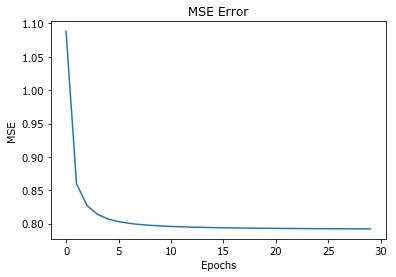

In [6]:
plt.plot(mse_list)
plt.title("MSE Error")
plt.xlabel("Epochs")
plt.ylabel("MSE")

#Updated ci to cj

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_j^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

In [7]:
# Questions
# How to decide the right K
# To calculate v^2 jk over sum of all j and k, is it over all j or particular j
# How to calculate db_i and db_j

2 * alpha * bi - 2 (yij - mu - bi - ci - ui^T*vj)

2 * alpha * cj - 2 (yij - mu - bi - ci - ui^T*vj)

# Task 2

In [8]:
gender_data = pd.read_csv('user_info.csv')

In [9]:
y = gender_data['is_male'].values
X = gender_data.drop('is_male', axis =1)

In [10]:
new_X = pd.concat([X, pd.DataFrame(U, columns=list('ABCDE'))], axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.25)

In [12]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
clf.score(X_test, y_test)

0.597457627118644

In [14]:
from sklearn.metrics import roc_auc_score
y_pred = clf.predict(np.array(X_test))
roc_auc_score(y_test, y_pred)

0.5378151260504203

## scaling U and VT

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
U_scaled = scaler.fit_transform(U)
VT_scaled = scaler.fit_transform(VT)

In [16]:
sorted_unique_users = np.sort(data.user_id.unique())
sorted_unique_movies = np.sort(data.item_id.unique())
N = len(data)

epoch = 30
learning_rate = random.choice([0.001,0.01,0.1,1,10,100])
reg_term = random.choice([0.001,0.01,0.1,1,10,100])

B = np.random.rand(sorted_unique_users.size) #Bias value B for users
C = np.random.rand(max(sorted_unique_movies)+1) #Bias value B for users
mu = data.rating.mean() #mu represents the mean of all the rating given in the dataset
y = data['rating'].values
y_pred = np.zeros(data.shape[0])
mse_list = []

print("Epoch_no \tmse_score")
for e in range(epoch):
    for index, (user, movie, rating) in enumerate(data.values):
        b_i, c_j = B[user], C[movie]
        
        #Dbi is dL/dbi
        Dbi = 2 * reg_term * b_i - 2 * (rating- mu - b_i - c_j - np.dot(U_scaled[user], VT_scaled.T[movie]))
        b_i = b_i - learning_rate * Dbi
        
        #Dcj is dL/dcj
        Dcj = 2 * reg_term * c_j - 2 * (rating - mu - b_i - c_j - np.dot(U_scaled[user], VT_scaled.T[movie]))
        c_j = c_j - learning_rate * Dcj
        
        #Updating b_i and c_j in B & C arrays
        B[user], C[movie] = b_i, c_j
        
        y_pred[index] = mu + b_i + c_j + np.dot(U_scaled[user], VT_scaled.T[movie])
    mse = mean_squared_error(y, y_pred)
    mse_list.append(mse)
    print(e, "\t",mse)

Epoch_no 	mse_score
0 	 13.804552821506416
1 	 9.112838312454372
2 	 7.851924334330101
3 	 7.330838886135253
4 	 7.05213920659876
5 	 6.876639145285128
6 	 6.753900368315021
7 	 6.661963461569701
8 	 6.589824974024179
9 	 6.531335075599372
10 	 6.48275367156266
11 	 6.441652347138368
12 	 6.406371433355669
13 	 6.3757294262230255
14 	 6.348856982964678
15 	 6.325096837228682
16 	 6.303940686561787
17 	 6.284987858384184
18 	 6.267917349101854
19 	 6.252468372875496
20 	 6.238426495170696
21 	 6.2256135321599935
22 	 6.21388005112602
23 	 6.203099706260709
24 	 6.193164894847303
25 	 6.183983380057747
26 	 6.175475632697321
27 	 6.167572715469684
28 	 6.160214582063829
29 	 6.15334869726591


Text(0, 0.5, 'MSE')

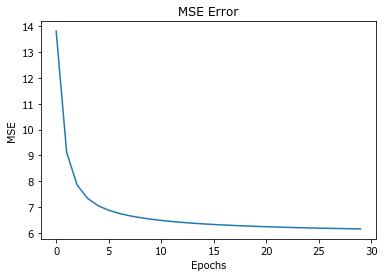

In [17]:
plt.plot(mse_list)
plt.title("MSE Error")
plt.xlabel("Epochs")
plt.ylabel("MSE")

Scaling of U & V matrices does not improve the martric